## Evaluating the Homer TF-peak scoring method

Homer `annotatePeaks.pl` attempts to find TF motif binding sites in a provided set of peak locations. The output of `annotatePeaks.pl` is a file for each TF with information about its binding potential to the peaks in your dataset. The columns are:

- PeakID
- Chromosome
- Peak start position
- Peak end position
- Strand
- Peak Score
- FDR/Peak Focus Ratio/Region Size
- Annotation (i.e. Exon, Intron, ...)
- Detailed Annotation (Exon, Intron etc. + CpG Islands, repeats, etc.)
- Distance to nearest RefSeq TSS
- Nearest TSS: Native ID of annotation file
- Nearest TSS: Entrez Gene ID
- Nearest TSS: Unigene ID
- Nearest TSS: RefSeq ID
- Nearest TSS: Ensembl ID
- Nearest TSS: Gene Symbol
- Nearest TSS: Gene Aliases
- Nearest TSS: Gene description
- Additional columns depend on options selected when running the program.

To test the Homer scoring method, we can have Homer predict the TF binding sites in ChIP-seq peaks with known TF binding interactions. We can compare the Homer predictions to the known TFs that bind to assess how well Homer identifies correct TF-peak binding partners.

So far, we have been evaluating our results against the mESC ground truth from the BEELINE paper. The paper does not provide the TF-peak ChIP-seq file, but rather the direct TF-TG mapping. The paper states that the ChIP-seq dataset was downloaded from ChIP-Atlas, so we are using the mm10 embryo ChIP: TFs and others dataset from ChIP-Atlas.

In [24]:
import os
import pandas as pd
import pybedtools
import seaborn as sns
import matplotlib.pyplot as plt

base_dir = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/"
ground_truth_dir = os.path.join(base_dir, "ground_truth_files")
output_dir = os.path.join(base_dir, "output/chipseq_homer")
tmp_dir = os.path.join(output_dir, "tmp")

os.makedirs(ground_truth_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)
os.makedirs(tmp_dir, exist_ok=True)

### ChIP-Atlas data

The ChIP-Atlas dataset we are using can be downloaded from:

`wget https://chip-atlas.dbcls.jp/data/mm10/assembled/Oth.Emb.05.AllAg.AllCell.bed`

This file corresponds to the following settings in the Peak Browser:
- Species -> M. musculus (mm10)
- Track type class -> ChIP: TFs and others
- Cell type class -> Embryo
- Threshold for Significance -> 50
- Track type -> All
- Cell type -> all

The first step here is to extract the relevant information from the ChIP-Atlas dataset to create a TF-peak ground truth DataFrame and a `homer_peaks.txt` DataFrame.

In [15]:
def extract_gene_name(name):
    return name.split("Name=")[1].split("%")[0]

def format_peak_id(chrom, start, end):
    start = str(int(start))
    end = str(int(end))
    return "%s:%s-%s" % (chrom, start, end)

chip_bed_file = os.path.join(ground_truth_dir, "Oth.Emb.05.AllAg.AllCell.bed")
chip_bed = pybedtools.BedTool(chip_bed_file)
chip_bed_df = chip_bed.to_dataframe()
chip_bed_nohead = chip_bed_df.iloc[1:, :].dropna()

chip_bed_nohead["gene_id"] = chip_bed_nohead["name"].apply(extract_gene_name)
chip_bed_cleaned = chip_bed_nohead[["chrom", "start", "end", "gene_id"]]

# Set the peak_id as the formatted peak location
chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)

chip_tf_to_peak = chip_bed_cleaned[["gene_id", "peak_id"]]
chip_tf_to_peak

/tmp/ipykernel_4068925/611637189.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chip_bed_cleaned["peak_id"] = chip_bed_cleaned.apply(lambda x: format_peak_id(x.chrom, x.start, x.end), axis=1)


,gene_id,peak_id
1,Smad4,chr1:3003564-3003922
2,Ctcf,chr1:3012605-3012815
3,Ctcf,chr1:3012635-3012824
4,Epitope,chr1:3031387-3031654
5,Smad4,chr1:3031454-3031677
...,...,...
7624387,Rest,chrY_JH584303_random:135985-136047
7624388,Rest,chrY_JH584303_random:135985-136048
7624389,Rest,chrY_JH584303_random:135986-136045
7624390,Rest,chrY_JH584303_random:135989-136043


Now that we have the ChIP-Atlas peaks in the format that we want, we can save it to the ground truth directory for later

In [ ]:
chip_tf_to_peak.to_csv(os.path.join(ground_truth_dir, "chipatlas_mESC.csv"), header=True, index=False)

### Creating the Homer peaks file

Next, we need to format the peaks to follow the requirements for the Homer peaks file.

> HOMER peak files should have at minimum 5 columns (separated by TABs, additional columns will be ignored:
> - Column1: Unique Peak ID
> - Column2: chromosome
> - Column3: starting position
> - Column4: ending position
> - Column5: Strand (+/- or 0/1, where 0="+", 1="-")

In [ ]:
# Format the DataFrame to follow the requirements for the Homer peaks file (used for both Homer and sliding window)
homer_peaks = chip_bed_cleaned[["peak_id", "chrom", "start", "end"]]
homer_peaks = homer_peaks.rename(columns={"peak_id":"PeakID", "chrom":"chr"})
homer_peaks["strand"] = ["."] * len(homer_peaks)
homer_peaks["start"] = round(homer_peaks["start"].astype(int),0)
homer_peaks["end"] = round(homer_peaks["end"].astype(int),0)
homer_peaks

,PeakID,chr,start,end,strand
1,chr1:3003564-3003922,chr1,3003564,3003922,.
2,chr1:3012605-3012815,chr1,3012605,3012815,.
3,chr1:3012635-3012824,chr1,3012635,3012824,.
4,chr1:3031387-3031654,chr1,3031387,3031654,.
5,chr1:3031454-3031677,chr1,3031454,3031677,.
...,...,...,...,...,...
7624387,chrY_JH584303_random:135985-136047,chrY_JH584303_random,135985,136047,.
7624388,chrY_JH584303_random:135985-136048,chrY_JH584303_random,135985,136048,.
7624389,chrY_JH584303_random:135986-136045,chrY_JH584303_random,135986,136045,.
7624390,chrY_JH584303_random:135989-136043,chrY_JH584303_random,135989,136043,.


This is a huge file - we dont need to test the method using all of them. We will take a sample to run the scoring on.

In [7]:
homer_peaks_sample = homer_peaks.sample(frac=0.05)

If we save the ChIP-seq peaks as `homer_peaks.txt` to the `tmp` directory of the output folder, then they will be used to calculate the sliding window and Homer scores

In [11]:
homer_peak_path = os.path.join(tmp_dir, "homer_peaks.txt")
homer_peaks_sample.to_csv(homer_peak_path, sep="\t", header=False, index=False)

### Running Homer

Now that we have created the ground truth TF-peak and `homer_peaks.txt` files, we can run Homer on the ChIP-seq peaks

In [ ]:
!sbatch /gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/dev/testing_scripts/run_homer_on_chipseq.sh

This bash script runs three processes:
1. Homer `findMotifsGenome.pl`, which identifies enriched TF binding motifs in the genome.
2. Homer `annotatePeaks.pl`, which matches TFs to a given set of peaks and provides mapping to the closet gene's TSS.
3. `homer_tf_peak_motifs.py`, which uses the output of `annotatePeaks.pl` to calculate a binding score between each TF and peak. The TF binding score for a peak is calculated by taking the number of TF binding motifs for the peak / total TF motifs across all peaks.

Once the bash script has finished, we can read in the output of `homer_tf_peak_motifs.py`, `homer_tf_to_peak.parquet`

### Comparing Homer TF-peak predictions vs ChIP-seq

In [13]:
homer_results = pd.read_parquet(os.path.join(output_dir, "homer_tf_to_peak.parquet"), engine="pyarrow")
homer_results = homer_results.reset_index(drop=True)
homer_results

,peak_id,source_id,homer_binding_score
0,chr7:83900579-83900792,AMYB,0.310261
1,chr7:101620490-101620805,AMYB,0.117482
2,chr7:34991075-34991272,AMYB,0.117482
3,chr1:128671539-128671848,AMYB,0.117482
4,chr18:77277089-77277325,AMYB,0.117482
...,...,...,...
13799777,chr1:93306294-93306671,GATA,1.000000
13799778,chr12:118643377-118643660,GATA,1.000000
13799779,chrX:111696748-111697080,GATA,1.000000
13799780,chr2:18027413-18027746,GATA,1.000000


We can use the `chip_tf_to_peak` object that we created from the ChIP-Atlas file to check our work. Since we sampled the ChIP-Atlas peaks before we ran Homer, we need to subset `chip_tf_to_peak` to only contain those peaks.

In [16]:
chip_tf_to_peak_sub = chip_tf_to_peak[chip_tf_to_peak["peak_id"].isin(homer_results["peak_id"])]
chip_tf_to_peak_sub

,gene_id,peak_id
16,Chd4,chr1:3043095-3043239
54,Neurog2,chr1:3094902-3095185
63,Ncor2,chr1:3113649-3113870
69,Hoxa13,chr1:3113912-3114136
114,Hoxa13,chr1:3139162-3139303
...,...,...
7624250,Ctcf,chrY:90839663-90839892
7624251,Ctcf,chrY:90839664-90839927
7624263,Ctcf,chrY:90839682-90839933
7624276,Ctcf,chrY:90839691-90839888


We then combine the TF-peak mapping from ChIP-Atlas with the TF-peak mapping from the Homer score by merging the two DataFrames on `peak_id`.

In [17]:
merged_df = pd.merge(chip_tf_to_peak_sub, homer_results, on="peak_id", how="inner")
merged_df = merged_df.rename(columns={"gene_id": "chip_gene", "source_id": "homer_gene"})
merged_df = merged_df[["chip_gene", "homer_gene", "peak_id", "homer_binding_score"]]
merged_df

,chip_gene,homer_gene,peak_id,homer_binding_score
0,Chd4,Atoh1,chr1:3043095-3043239,0.190848
1,Chd4,Hoxa11,chr1:3043095-3043239,0.029915
2,Chd4,BHLHA15,chr1:3043095-3043239,0.010248
3,Chd4,BMAL1,chr1:3043095-3043239,0.084044
4,Chd4,MITF,chr1:3043095-3043239,0.246287
...,...,...,...,...
14038576,Foxa2,Foxa2,chrY:90841573-90841784,0.318534
14038577,Foxa2,Foxa3,chrY:90841573-90841784,0.776944
14038578,Foxa2,Foxf1,chrY:90841573-90841784,0.172716
14038579,Foxa2,Foxo1,chrY:90841573-90841784,0.075228


In [18]:
merged_df.to_csv(os.path.join(output_dir, "chipseq_homer_merged.csv"), header=True, index=False)

We can extract the correct predictions and the incorrect predictions, and see how the Homer binding scores vary between them.

In [21]:
correct_predictions = merged_df[merged_df["chip_gene"] == merged_df["homer_gene"]]
incorrect_predictions = merged_df[merged_df["chip_gene"] != merged_df["homer_gene"]]

print(f"Num correct predictions: {len(correct_predictions)}")
print(f"Num incorrect predictions: {len(incorrect_predictions)}")

Num correct predictions: 33255
Num incorrect predictions: 14005326


There are a lot more incorrect predictions than correct predictions. We will sample each DataFrame by the one with the minimum number of rows so they are equal in length.

In [22]:
correct_prediction_scores = correct_predictions["homer_binding_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Correct TF Binding Predictions").reset_index(drop=True)

incorrect_prediction_scores = incorrect_predictions["homer_binding_score"].sample(
    min(len(correct_predictions), len(incorrect_predictions))
    ).rename("Incorrect TF Binding Predictions").reset_index(drop=True)

print(f"Num correct predictions: {len(correct_prediction_scores)}")
print(f"Num incorrect predictions: {len(incorrect_prediction_scores)}")

Num correct predictions: 33255
Num incorrect predictions: 33255


Now that we have extracted the correct and incorrect scores, we will merge them to create a new dataframe containing just the correct and incorrect scores.

In [23]:
pred_df = pd.merge(correct_prediction_scores, incorrect_prediction_scores, left_index=True, right_index=True)

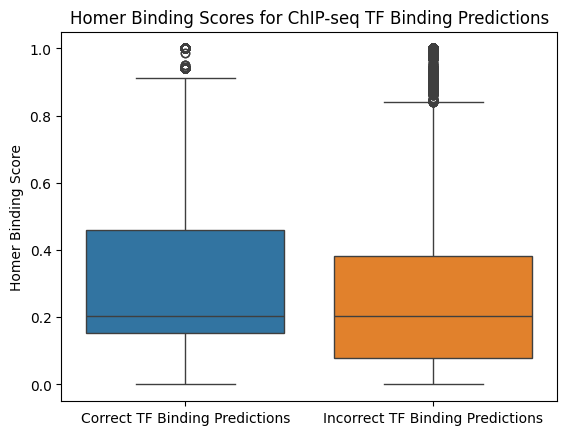

In [25]:
fig = plt.Figure()
a = sns.boxplot(data=pred_df)
a.set_ylabel("Homer Binding Score")
a.set_title("Homer Binding Scores for ChIP-seq TF Binding Predictions")
plt.savefig(os.path.join(output_dir, "chipseq_homer_boxplot.png"), dpi=200)

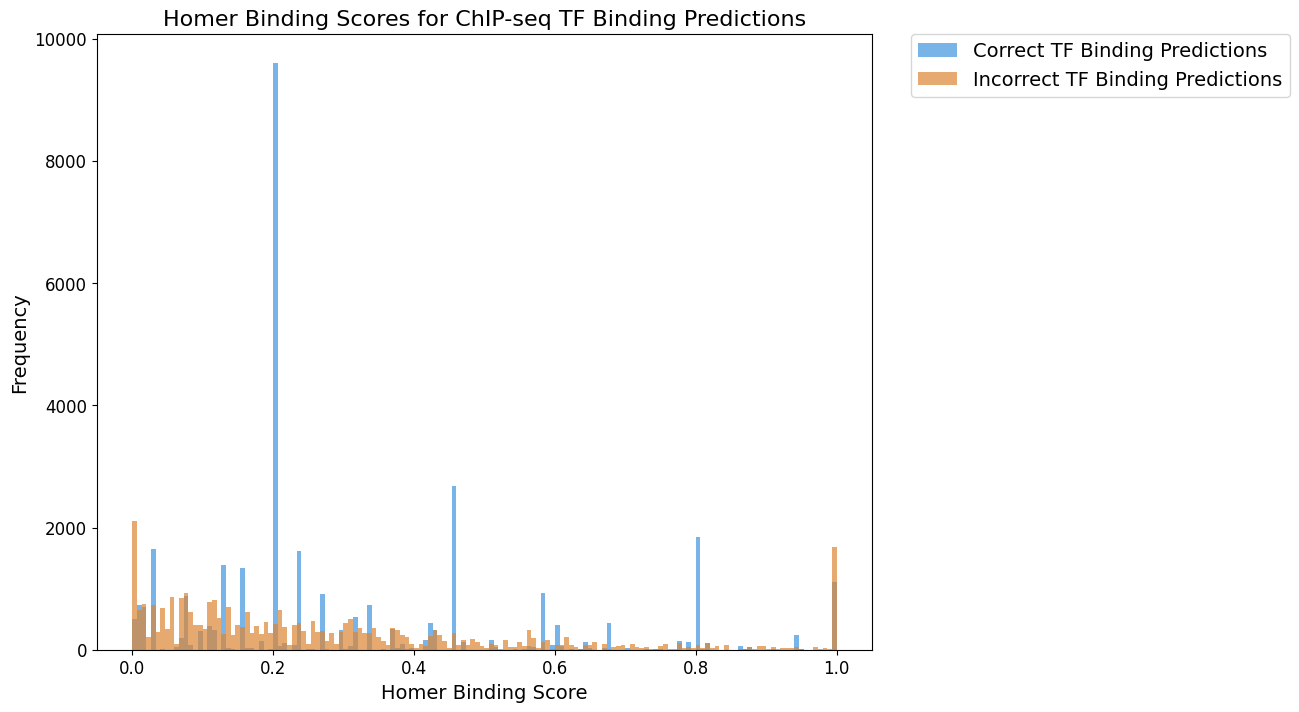

In [26]:
plt.figure(figsize=(10,8))
plt.hist(
    pred_df["Correct TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#4195df',
    label="Correct TF Binding Predictions"
)
plt.hist(
    pred_df["Incorrect TF Binding Predictions"],
    bins=150,
    alpha=0.7,
    color='#dc8634',
    label="Incorrect TF Binding Predictions"
)
plt.title("Homer Binding Scores for ChIP-seq TF Binding Predictions", fontsize=16)
plt.xlabel("Homer Binding Score", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=14)
plt.savefig(os.path.join(output_dir, "chipseq_homer_histogram.png"), dpi=200)